In [6]:
import math
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.transform import rotate

def bboxes_to_grasps(box):
    x = box[0][0] + (box[2][0] - box[0][0]) / 2
    y = box[0][1] + (box[2][1] - box[0][1]) / 2
    tan = (box[2][0] - box[3][0]) / (box[2][1] - box[3][1] + 1e-6)  # add a small epsilon to prevent division by zero
    w = math.sqrt((box[0][0] - box[1][0]) ** 2 + (box[0][1] - box[1][1]) ** 2)
    h = math.sqrt((box[0][0] - box[3][0]) ** 2 + (box[0][1] - box[3][1]) ** 2)
    theta = math.degrees(math.atan(tan))
    if theta < 0:
        theta += 90
    else:
        theta -= 90
    theta = 360 + theta if theta < 0 else theta
    return round(x, 3), round(y, 3), round(theta, 3), round(w, 3), round(h, 3)

def augment_image(image, depth, bbox):
    angle = np.random.randint(-180, 180)
    tx = np.random.randint(-50, 50)
    ty = np.random.randint(-50, 50)
    M = np.float32([[1, 0, tx], [0, 1, ty]])

    rotated_image = rotate(image, angle, resize=True)
    rotated_depth = rotate(depth, angle, resize=True)
    translated_image = cv2.warpAffine(rotated_image, M, (rotated_image.shape[1], rotated_image.shape[0]))
    translated_depth = cv2.warpAffine(rotated_depth, M, (rotated_depth.shape[1], rotated_depth.shape[0]))

    grasps = [bboxes_to_grasps(box) for box in bbox]
    return translated_image, translated_depth, grasps

def visualize_grasps(image, grasps):
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for grasp in grasps:
        x, y, theta, w, h = grasp
        rect = patches.Rectangle((x-w/2, y-h/2), w, h, angle=theta, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

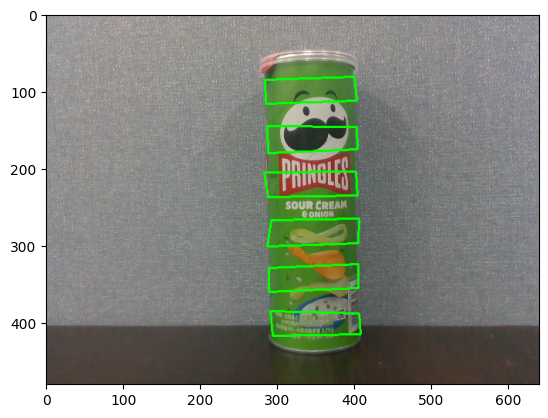

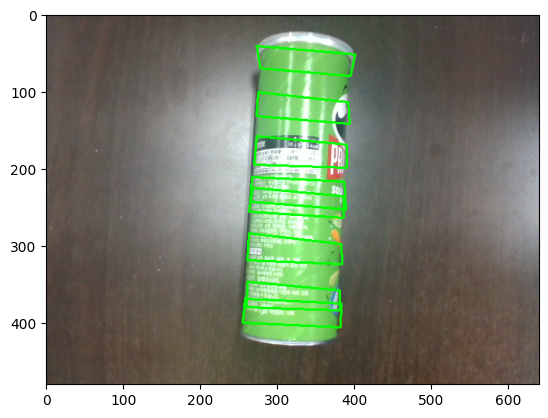

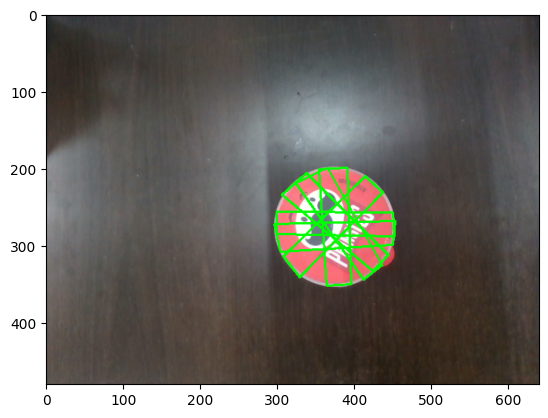

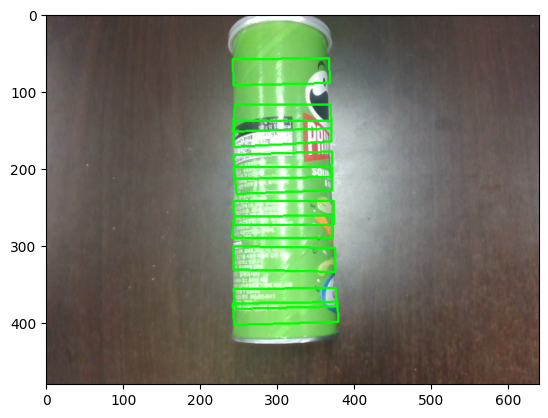

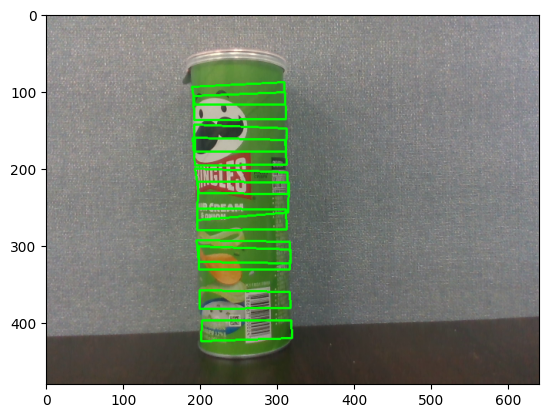

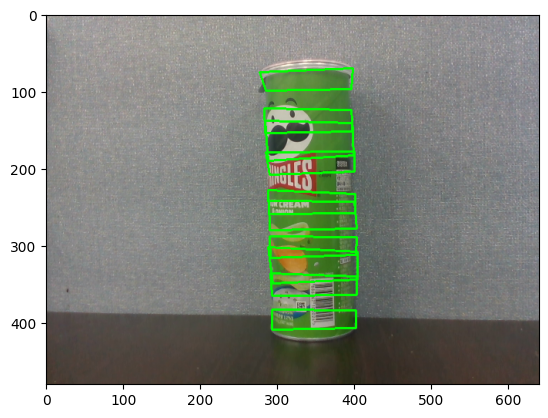

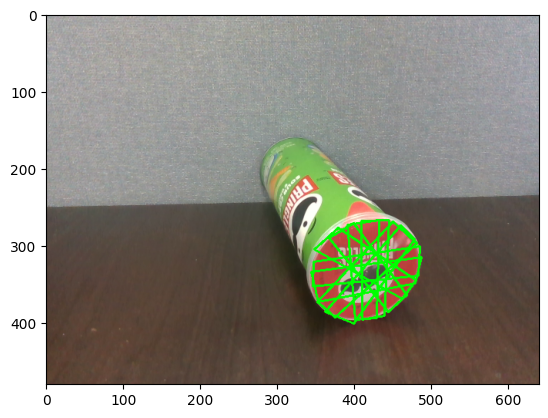

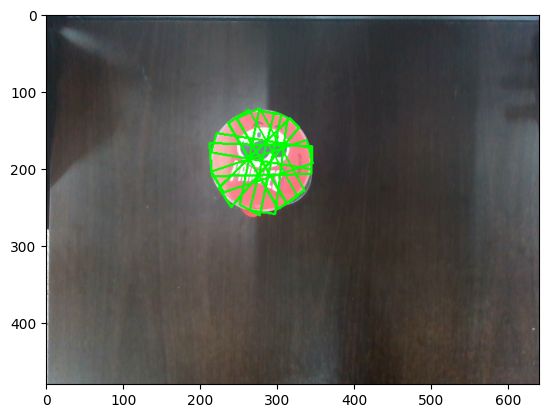

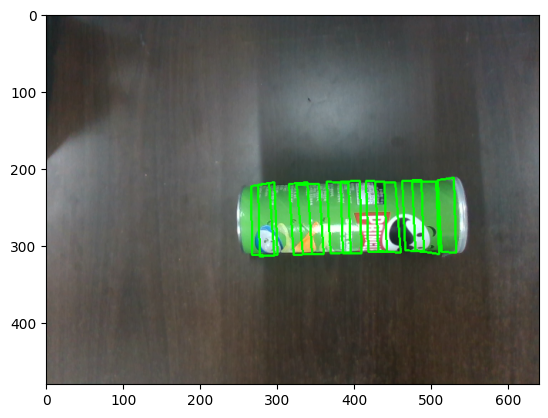

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

dataset_dir = 'rgbd_dataset'
annotations_dir = 'rgbd_dataset_annotations'

image_files = [f for f in os.listdir(dataset_dir) if f.startswith('rgb')]

for image_file in image_files:
    image_path = os.path.join(dataset_dir, image_file)
    image = cv2.imread(image_path)

    depth_file = image_file.replace('rgb', 'depth')
    depth_path = os.path.join(dataset_dir, depth_file)
    depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)  # read depth image

    annotation_file = image_file.replace('.png', '_cpos.txt')
    annotation_path = os.path.join(annotations_dir, annotation_file)

    with open(annotation_path, 'r') as f:
        lines = f.readlines()
        annotations = [(lines[i], lines[i+1], lines[i+2], lines[i+3]) for i in range(0, len(lines), 4)]

    for annotation in annotations:
        bbox = [tuple(map(int, point.strip().split())) for point in annotation]  # use annotation as bbox

        for i in range(4):
            cv2.line(image, bbox[i], bbox[(i+1)%4], (0, 255, 0), 2)
            augmented_image, augmented_depth, grasps = augment_image(image, depth, [bbox])
            visualize_grasps(augmented_image, grasps)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

In [5]:


dataset_dir = 'rgbd_dataset'
annotations_dir = 'rgbd_dataset_annotations'
file = 'rgb_10.png'

img = cv2.imread(os.path.join(dataset_dir, file))
depth = cv2.imread(os.path.join(dataset_dir, file.replace('rgb', 'depth')), cv2.IMREAD_UNCHANGED)


augmented_image, augmented_depth, grasps = augment_image(img, depth, [bbox])
visualize_grasps(augmented_image, grasps)

[ WARN:0@117.551] global loadsave.cpp:248 findDecoder imread_('rgbd_dataset/rgb_9.png'): can't open/read file: check file path/integrity
[ WARN:0@117.551] global loadsave.cpp:248 findDecoder imread_('rgbd_dataset/depth_9.png'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'